In [ ]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, f1_score
from imblearn.over_sampling import SMOTE
from lime.lime_tabular import LimeTabularExplainer

warnings.filterwarnings('ignore')

In [2]:
kidney_data = pd.read_csv('../b. Datasets/Chronic Kidney Disease Classification/Chronic Kidney Disease Dataset.csv')

In [3]:
kidney_data.shape

(158, 26)

In [4]:
display(kidney_data.head(2))
display(kidney_data.tail(2))

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,3,48,70,1.005,4,0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
1,9,53,90,1.020,2,0,abnormal,abnormal,present,notpresent,...,29,12100,3.7,yes,yes,no,poor,no,yes,ckd


,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
156,398,17,60,1.025,0,0,normal,normal,notpresent,notpresent,...,51,7200,5.9,no,no,no,good,no,no,notckd
157,399,58,80,1.025,0,0,normal,normal,notpresent,notpresent,...,53,6800,6.1,no,no,no,good,no,no,notckd


In [5]:
kidney_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,158.0,274.841772,102.998517,3.000,243.00,298.50,355.750,399.000
age,158.0,49.563291,15.512244,6.000,39.25,50.50,60.000,83.000
bp,158.0,74.050633,11.175381,50.000,60.00,80.00,80.000,110.000
sg,142.0,1.019965,0.005570,1.005,1.02,1.02,1.025,1.025
al,158.0,0.797468,1.413130,0.000,0.00,0.00,1.000,4.000
su,158.0,0.253165,0.813397,0.000,0.00,0.00,0.000,5.000
bgr,158.0,131.341772,64.939832,70.000,97.00,115.50,131.750,490.000
bu,158.0,52.575949,47.395382,10.000,26.00,39.50,49.750,309.000
sc,158.0,2.188608,3.077615,0.400,0.70,1.10,1.600,15.200
sod,158.0,138.848101,7.489421,111.000,135.00,139.00,144.000,150.000


In [6]:
kidney_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              158 non-null    int64  
 1   age             158 non-null    int64  
 2   bp              158 non-null    int64  
 3   sg              142 non-null    float64
 4   al              158 non-null    int64  
 5   su              158 non-null    int64  
 6   rbc             158 non-null    object 
 7   pc              158 non-null    object 
 8   pcc             158 non-null    object 
 9   ba              158 non-null    object 
 10  bgr             158 non-null    int64  
 11  bu              158 non-null    int64  
 12  sc              158 non-null    float64
 13  sod             158 non-null    int64  
 14  pot             158 non-null    float64
 15  hemo            158 non-null    float64
 16  pcv             158 non-null    int64  
 17  wc              158 non-null    int

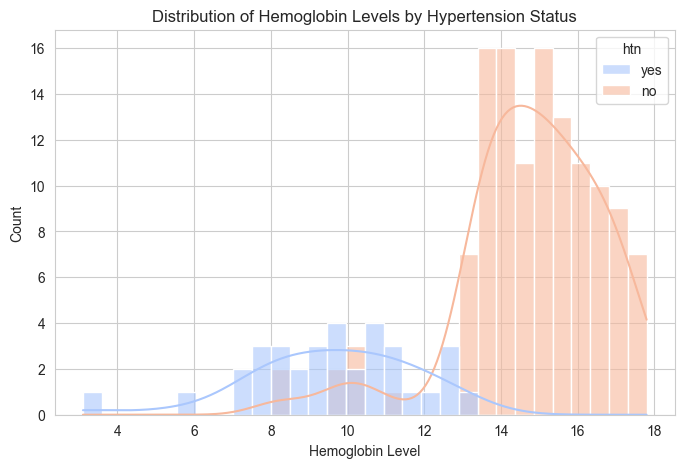

In [7]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))

sns.histplot(data=kidney_data, x='hemo', hue='htn', 
             kde=True, bins=30, alpha=0.6, 
             palette='coolwarm')

plt.xlabel("Hemoglobin Level")
plt.ylabel("Count")
plt.title("Distribution of Hemoglobin Levels by Hypertension Status")
plt.show()

In [8]:
kidney_data.isna().sum()

id                 0
age                0
bp                 0
sg                16
al                 0
su                 0
rbc                0
pc                 0
pcc                0
ba                 0
bgr                0
bu                 0
sc                 0
sod                0
pot                0
hemo               0
pcv                0
wc                 0
rc                 0
htn                0
dm                 0
cad                0
appet              0
pe                 0
ane                0
classification     0
dtype: int64

In [9]:
kidney_data.dropna(inplace=True)

In [10]:
kidney_data.isna().sum().sum()

0

In [11]:
numerical_features = kidney_data.select_dtypes(include='number').columns
numerical_features

Index(['id', 'age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot',
       'hemo', 'pcv', 'wc', 'rc'],
      dtype='object')

In [12]:
categorical_features = kidney_data.select_dtypes(include='object').columns
categorical_features

Index(['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane',
       'classification'],
      dtype='object')

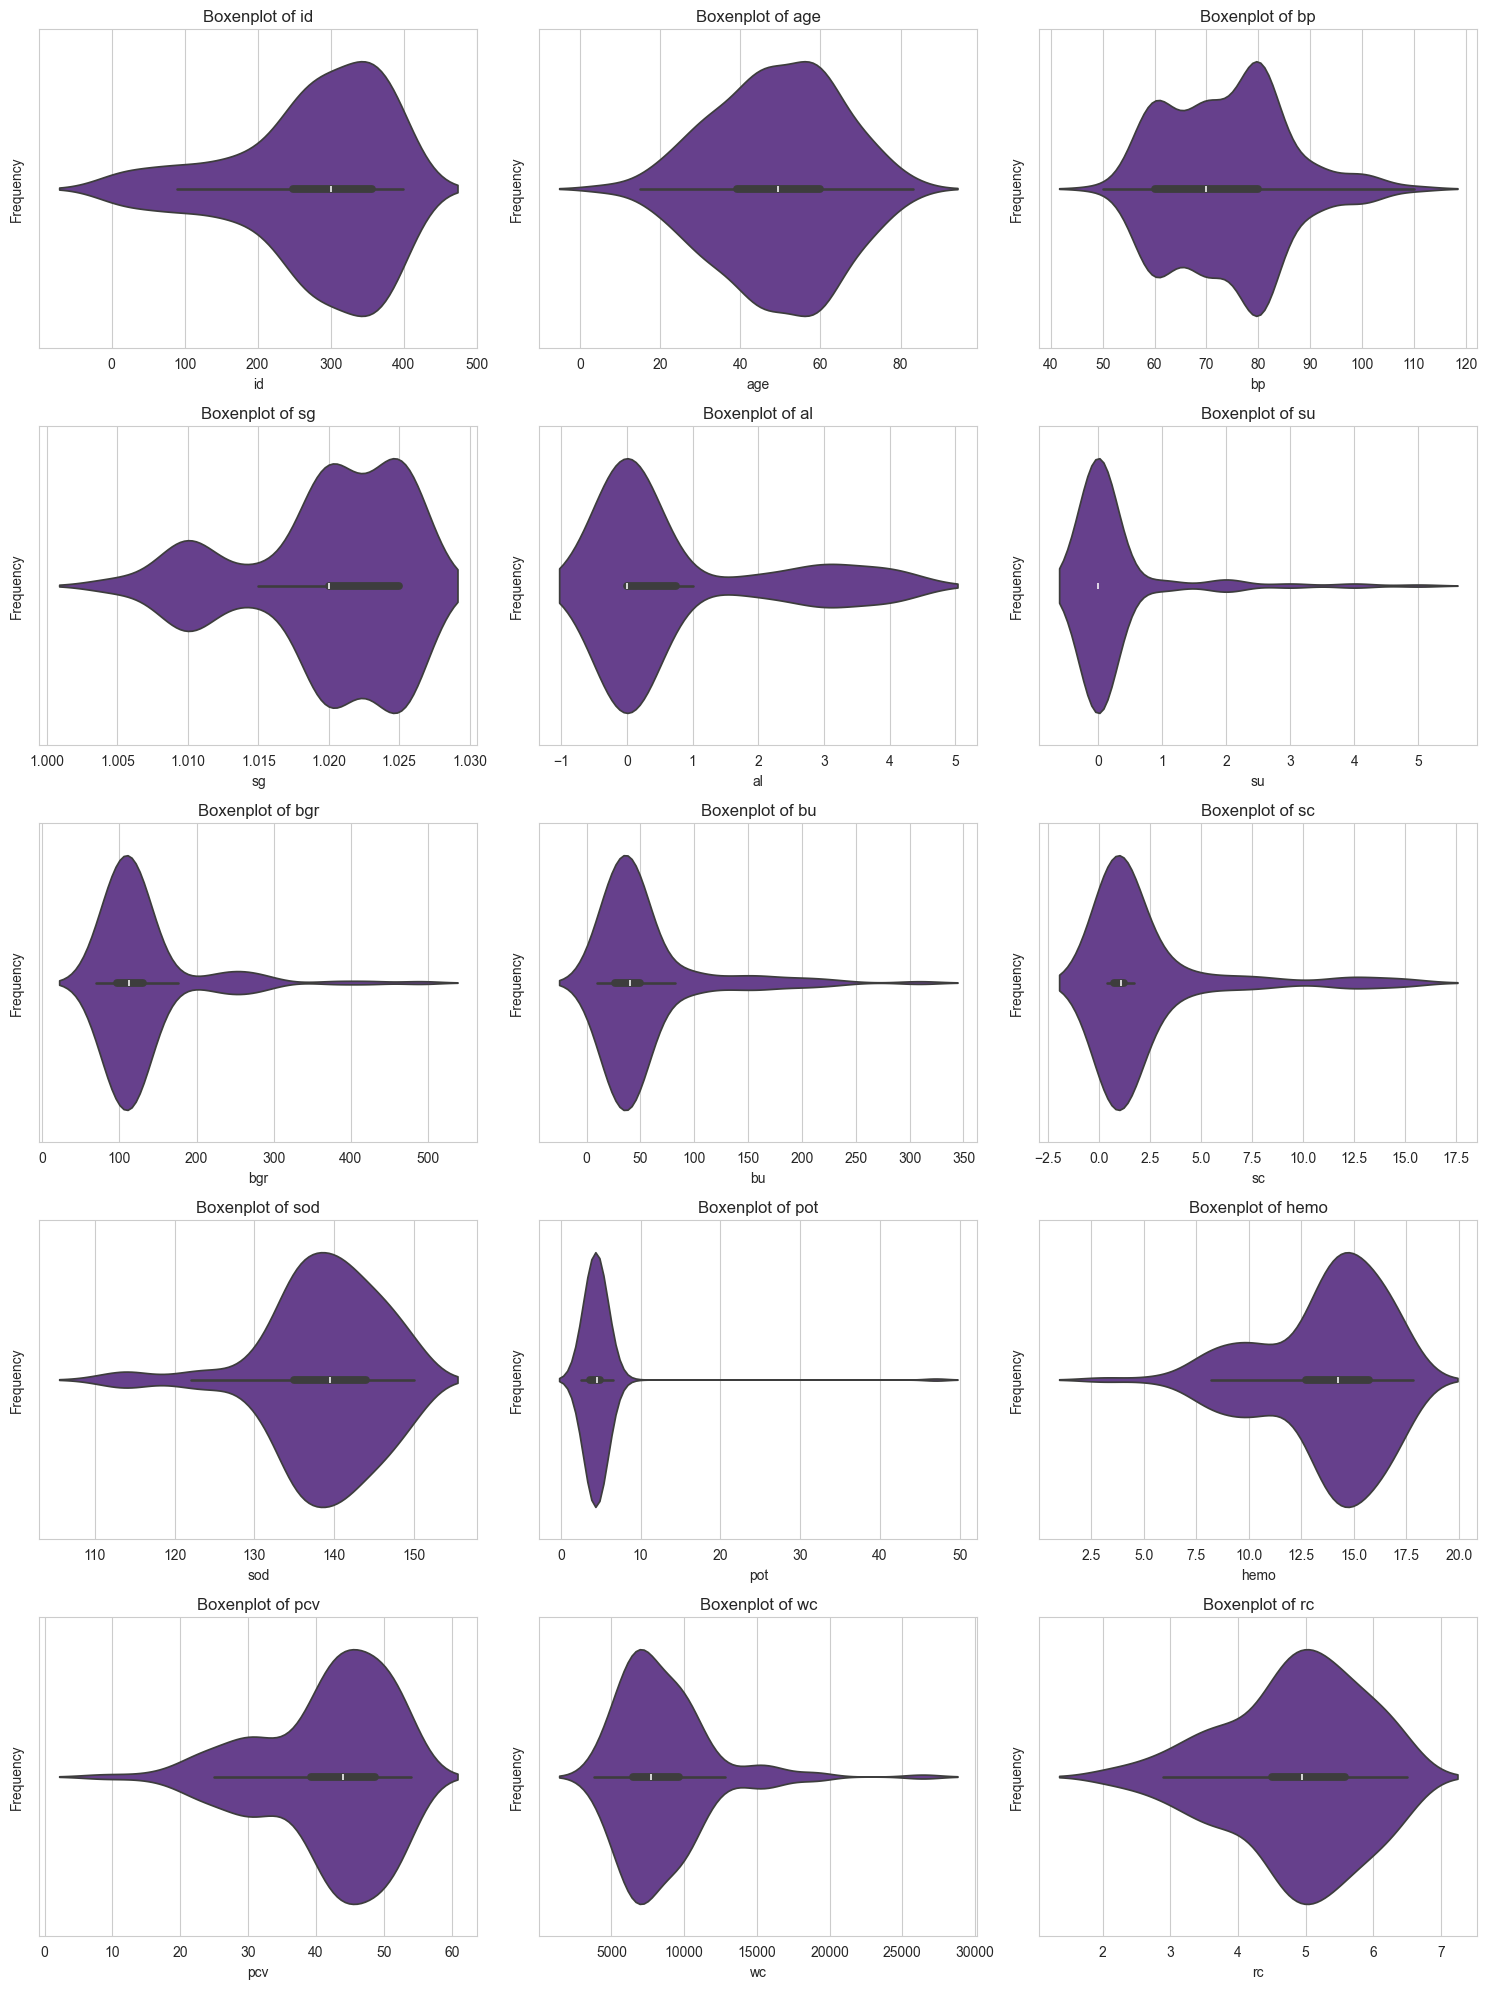

In [13]:
num_columns = kidney_data.select_dtypes(include='number').columns

n_cols = 3 
n_rows = (len(num_columns) + n_cols - 1) // n_cols 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))

axes = axes.flatten()

for i, column in enumerate(num_columns):
    sns.violinplot(data=kidney_data, x=column, ax=axes[i], color='rebeccapurple')
    axes[i].set_title(f'Boxenplot of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [14]:
kidney_data_encoded = pd.get_dummies(kidney_data, columns=kidney_data.select_dtypes(include='object').columns, drop_first=True)
kidney_data_encoded.head(2)

,id,age,bp,sg,al,su,bgr,bu,sc,sod,...,pc_normal,pcc_present,ba_present,htn_yes,dm_yes,cad_yes,appet_poor,pe_yes,ane_yes,classification_notckd
0,3,48,70,1.005,4,0,117,56,3.8,111,...,False,True,False,True,False,False,True,True,True,False
1,9,53,90,1.020,2,0,70,107,7.2,114,...,False,True,False,True,True,False,True,False,True,False


In [15]:
kidney_data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142 entries, 0 to 157
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     142 non-null    int64  
 1   age                    142 non-null    int64  
 2   bp                     142 non-null    int64  
 3   sg                     142 non-null    float64
 4   al                     142 non-null    int64  
 5   su                     142 non-null    int64  
 6   bgr                    142 non-null    int64  
 7   bu                     142 non-null    int64  
 8   sc                     142 non-null    float64
 9   sod                    142 non-null    int64  
 10  pot                    142 non-null    float64
 11  hemo                   142 non-null    float64
 12  pcv                    142 non-null    int64  
 13  wc                     142 non-null    int64  
 14  rc                     142 non-null    float64
 15  rbc_normal 

In [16]:
kidney_data_encoded.rename(columns={'classification_notckd': 'classification'}, inplace=True)
kidney_data_encoded.head(2)

,id,age,bp,sg,al,su,bgr,bu,sc,sod,...,pc_normal,pcc_present,ba_present,htn_yes,dm_yes,cad_yes,appet_poor,pe_yes,ane_yes,classification
0,3,48,70,1.005,4,0,117,56,3.8,111,...,False,True,False,True,False,False,True,True,True,False
1,9,53,90,1.020,2,0,70,107,7.2,114,...,False,True,False,True,True,False,True,False,True,False


In [17]:
related_fields = []
not_related_fields = []

significance_value = 0.05

for feature in numerical_features:
    if feature == 'classification':
        continue
    group1 = kidney_data_encoded[kidney_data_encoded['classification'] == 0][feature]
    group2 = kidney_data_encoded[kidney_data_encoded['classification'] == 1][feature]

    # Perform t-test (assuming unequal variance)
    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False, nan_policy='omit')

    if p_value < significance_value:
        related_fields.append(feature)
    else:
        not_related_fields.append(feature)


print("Features that are related with 'Classification'", related_fields)
print("\nFeatures that are NOT related with 'Classification'", not_related_fields)

Features that are related with 'Classification' ['id', 'age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'hemo', 'pcv', 'wc', 'rc']

Features that are NOT related with 'Classification' ['pot']


In [18]:
related_fields = []
not_related_fields = []

significance_value = 0.05

for feature in kidney_data_encoded.columns:
    if feature == 'classification':
        continue

    else:  # Categorical feature -> Chi-square test
        crosstab_vals = pd.crosstab(kidney_data_encoded[feature], kidney_data_encoded['classification'])
        
        if crosstab_vals.shape[0] < 2:
            not_related_fields.append(feature)
            continue
        
        chi2_stat, p_value, _, _ = stats.chi2_contingency(crosstab_vals)
    
    # Check significance
    if p_value < significance_value:
        related_fields.append(feature)
    else:
        not_related_fields.append(feature)

print("Features that are related with 'Classification'", related_fields)
print("\nFeatures that are NOT related with 'Classification'", not_related_fields)

Features that are related with 'Classification' ['bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'rbc_normal', 'pc_normal', 'pcc_present', 'ba_present', 'htn_yes', 'dm_yes', 'cad_yes', 'appet_poor', 'pe_yes', 'ane_yes']

Features that are NOT related with 'Classification' ['id', 'age']


In [19]:
kidney_data_encoded.classification.value_counts()

classification
True     105
False     37
Name: count, dtype: int64

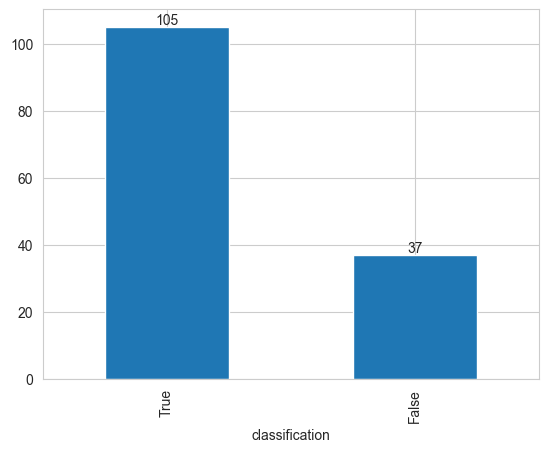

In [20]:
barplot = kidney_data_encoded.classification.value_counts().plot(kind='bar')
plt.bar_label(barplot.containers[0], label_type='edge')
plt.show()

In [21]:
X = kidney_data_encoded.drop(labels='classification', axis=1)
y = kidney_data_encoded['classification']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=0)

In [23]:
X_train_features = X_train.columns
X_test_features = X_test.columns

standard_scaler = StandardScaler()

X_train = pd.DataFrame(data=standard_scaler.fit_transform(X_train), columns=X_train_features)
X_test = pd.DataFrame(data=standard_scaler.transform(X_test), columns=X_test_features)

In [24]:
X_train

,id,age,bp,sg,al,su,bgr,bu,sc,sod,...,rbc_normal,pc_normal,pcc_present,ba_present,htn_yes,dm_yes,cad_yes,appet_poor,pe_yes,ane_yes
0,0.789617,-0.164931,-1.148777,0.000000,-0.570104,-0.314468,-0.171425,-0.638977,-0.344111,-0.121041,...,0.335201,0.455321,-0.316228,-0.296500,-0.518875,-0.471405,-0.254000,-0.353553,-0.371391,-0.316228
1,-0.047720,-0.232126,-1.148777,0.948683,-0.570104,-0.314468,-0.079690,-0.161703,-0.402949,-0.549007,...,0.335201,0.455321,-0.316228,-0.296500,-0.518875,-0.471405,-0.254000,-0.353553,-0.371391,-0.316228
2,-0.182107,-0.500903,0.475922,0.000000,-0.570104,-0.314468,0.057914,-0.599204,-0.491206,0.164270,...,0.335201,0.455321,-0.316228,-0.296500,-0.518875,-0.471405,-0.254000,-0.353553,-0.371391,-0.316228
3,-1.091806,-1.911984,1.288271,-1.897367,2.287631,-0.314468,-0.324318,-0.281021,-0.197017,-1.975562,...,0.335201,-2.196253,3.162278,3.372684,-0.518875,-0.471405,-0.254000,-0.353553,-0.371391,3.162278
4,0.686242,-0.769680,0.475922,0.000000,-0.570104,-0.314468,-0.446633,-0.698636,-0.550043,1.162858,...,0.335201,0.455321,-0.316228,-0.296500,-0.518875,-0.471405,-0.254000,-0.353553,-0.371391,-0.316228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,-1.960156,1.447732,-0.336427,-1.897367,1.573198,-0.314468,1.388083,0.554208,0.361941,-0.834318,...,0.335201,-2.196253,3.162278,3.372684,1.927248,2.121320,3.937004,-0.353553,-0.371391,-0.316228
95,-0.037382,-0.097737,-1.148777,0.000000,-0.570104,-0.314468,-0.247872,-0.201476,-0.344111,0.449581,...,0.335201,0.455321,-0.316228,-0.296500,-0.518875,-0.471405,-0.254000,-0.353553,-0.371391,-0.316228
96,0.469155,-1.307235,-1.148777,0.948683,-0.570104,-0.314468,-0.125558,-0.459999,-0.461787,1.590824,...,0.335201,0.455321,-0.316228,-0.296500,-0.518875,-0.471405,-0.254000,-0.353553,-0.371391,-0.316228
97,0.365780,0.574206,-0.336427,0.000000,-0.570104,-0.314468,-0.400765,-0.121930,-0.344111,0.021614,...,0.335201,0.455321,-0.316228,-0.296500,-0.518875,-0.471405,-0.254000,-0.353553,-0.371391,-0.316228


In [25]:
dc_model = DecisionTreeClassifier()
dc_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [26]:
y_test_pred = dc_model.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.9767441860465116

In [27]:
y_test_pred

array([False,  True, False,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True, False, False,  True, False,  True,  True,
        True,  True, False,  True,  True, False, False,  True,  True,
        True,  True, False,  True, False,  True,  True])

In [28]:
confusion_matrix(y_test, y_test_pred)

array([[11,  0],
       [ 1, 31]], dtype=int64)

In [29]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.92      1.00      0.96        11
        True       1.00      0.97      0.98        32

    accuracy                           0.98        43
   macro avg       0.96      0.98      0.97        43
weighted avg       0.98      0.98      0.98        43



In [30]:
roc_auc_score(y_test, y_test_pred)

0.984375

In [31]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)

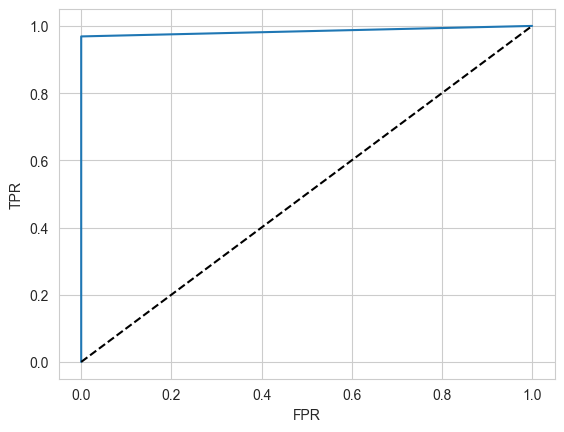

In [32]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('FPR')
plt.ylabel("TPR")
plt.show()

In [33]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_train, y_train)

RandomForestClassifier()

In [34]:
y_test_pred = rfc_model.predict(X_test)

In [35]:
accuracy_score(y_test, y_test_pred)

1.0

In [36]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00        11
        True       1.00      1.00      1.00        32

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43



In [37]:
confusion_matrix(y_test, y_test_pred)

array([[11,  0],
       [ 0, 32]], dtype=int64)

In [38]:
smote = SMOTE()
X, y = smote.fit_resample(X, y)

In [39]:
X.shape

(210, 25)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, random_state=0)

In [41]:
dc_model.fit(X_train, y_train)
y_test_pred = dc_model.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.9811320754716981

In [42]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.96      1.00      0.98        27
        True       1.00      0.96      0.98        26

    accuracy                           0.98        53
   macro avg       0.98      0.98      0.98        53
weighted avg       0.98      0.98      0.98        53



In [43]:
confusion_matrix(y_test, y_test_pred)

array([[27,  0],
       [ 1, 25]], dtype=int64)

In [44]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
y_test_pred = knn_model.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.8113207547169812

In [45]:
bayes_model = GaussianNB()
bayes_model.fit(X_train, y_train)
y_test_pred = bayes_model.predict(X_test)
accuracy_score(y_test, y_test_pred)

1.0

In [46]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00        27
        True       1.00      1.00      1.00        26

    accuracy                           1.00        53
   macro avg       1.00      1.00      1.00        53
weighted avg       1.00      1.00      1.00        53



In [47]:
f1_score(y_test, y_test_pred)

1.0

In [48]:
submission_df = pd.DataFrame({
    'Index': X_test.index,
    'Classification': y_test_pred
}).sort_values(by="Index", ascending=True)
submission_df.head(2)

,Index,Classification
39,9,False
3,12,False


In [49]:
submission_df.to_csv('../d. Output Files/Chronic Kidney Disease Classification/Chronic Kidney Disease Classification.csv', index=False)

In [50]:
explainer = LimeTabularExplainer(X_train.values, feature_names=X_train.columns, mode='classification')
exp = explainer.explain_instance(X_test.iloc[0].values, bayes_model.predict_proba)
exp.show_in_notebook()